# Experiment Comparison

In this notebook, we will compare the results of our simulator with real data from AWS Lambda.

In [1]:
# imports

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# using Modin and Dask for parallelization:
# from distributed import Client
# client = Client(n_workers=4)
# # Modin will connect to the Dask Client
# import modin.pandas as pd

In [2]:
from simfaas.ServerlessSimulator import ServerlessSimulator as Sim


def process_aws(arrival_rate, st_w, st_c, max_time=1e6):
    sim = Sim(arrival_rate=arrival_rate,
                warm_service_rate=1/st_w, 
                cold_service_rate=1/st_c,
                expiration_threshold=600, 
                max_time=max_time)
    sim.generate_trace(debug_print=False, progress=True)
    return pd.Series(sim.get_result_dict())

In [3]:
import time

# load experiments
exp_df = pd.read_csv('exp.csv', index_col=0)

st_w_avg = exp_df['ServiceTimeWarm'].mean()
st_c_avg = exp_df['ServiceTimeCold'].mean()

def get_row_cold_prob(x):
    return process_aws(
        arrival_rate=x['ArrivalRate'],
        st_w=st_w_avg / 1000,
        st_c=st_c_avg / 1000,
    )

start_time = time.time()
sim_df = exp_df.apply(get_row_cold_prob, axis=1)
print(f"\n\nCalculation took {time.time() - start_time}")

100%|██████████| 1000000/1000000 [00:53<00:00, 18612.28it/s]


Calculation took 294.61674904823303


In [4]:
sim_df.head()

,reqs_cold,reqs_total,reqs_warm,prob_cold,reqs_reject,prob_reject,lifespan_avg,inst_count_avg,inst_running_count_avg,inst_idle_count_avg
experiment_13,608.0,1900.0,1292.0,0.320000,0.0,0.0,1150.356526,0.698237,0.004093,0.694144
experiment_14,586.0,2425.0,1839.0,0.241649,0.0,0.0,1320.903389,0.773740,0.005009,0.768730
experiment_15,526.0,2912.0,2386.0,0.180632,0.0,0.0,1605.098900,0.843160,0.005837,0.837322
experiment_16,459.0,3487.0,3028.0,0.131632,0.0,0.0,1944.735491,0.890678,0.007149,0.883529
experiment_17,355.0,4291.0,3936.0,0.082731,0.0,0.0,2659.598302,0.942207,0.008535,0.933672


In [5]:
exp_df.head()

,ArrivalRate,ServiceTimeWarm,ServiceTimeCold,IdleMinutesBeforeKill,AverageInstanceCount,AverageUtilization,ColdStartProbability,ColdStartProbabilitySE,AverageRunningInstances,AverageIdleInstances
experiment_13,0.001863,1955.000047,2563.417463,10.0,0.674194,0.002392,0.342988,0.031763,0.001613,0.672581
experiment_14,0.002458,1954.200784,2462.750852,10.0,0.813505,0.004950,0.210828,0.037085,0.004019,0.809486
experiment_15,0.002882,1952.411077,2536.062641,10.0,0.779471,0.007202,0.145431,0.024181,0.006415,0.773055
experiment_16,0.003453,1959.825125,2430.141293,10.0,0.907570,0.005376,0.110098,0.022802,0.004781,0.902789
experiment_17,0.004248,1958.281446,2397.801421,10.0,0.945903,0.011130,0.079480,0.012393,0.010342,0.935561


Cold Start MAPE: 12.88%
Cold Start Standard Error (SE): 10.14%


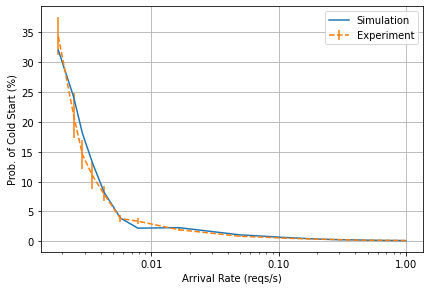

In [6]:
from matplotlib.ticker import ScalarFormatter

plt.semilogx(exp_df['ArrivalRate'], sim_df['prob_cold'] * 100, label='Simulation')
plt.errorbar(exp_df['ArrivalRate'], exp_df['ColdStartProbability']
         * 100, yerr=exp_df['ColdStartProbabilitySE'] * 100, ls='--', label='Experiment')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylabel("Prob. of Cold Start (%)")
plt.xlabel('Arrival Rate (reqs/s)')
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gcf().subplots_adjust(left=0.09, bottom=0.11)

mape = np.mean(np.abs((sim_df['prob_cold'] - exp_df['ColdStartProbability'])/exp_df['ColdStartProbability']*100))
print(f"Cold Start MAPE: {mape:4.2f}%")
cold_start_se = np.mean(exp_df['ColdStartProbabilitySE']/exp_df['ColdStartProbability']) * 100
print(f"Cold Start Standard Error (SE): {cold_start_se:4.2f}%")

plt.savefig('figs/04-exp-pcold.pdf')

Average Instance MAPE: 3.43%


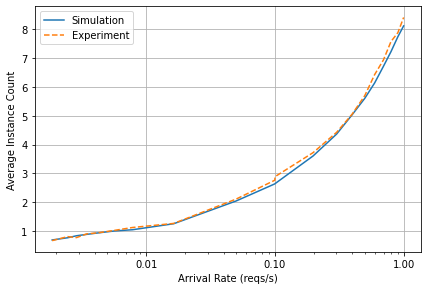

In [7]:
plt.semilogx(exp_df['ArrivalRate'], sim_df['inst_count_avg'], label='Simulation')
plt.semilogx(exp_df['ArrivalRate'], exp_df['AverageInstanceCount'], ls='--', label='Experiment')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylabel("Average Instance Count")
plt.xlabel('Arrival Rate (reqs/s)')
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gcf().subplots_adjust(left=0.08, bottom=0.11)

plt.savefig('figs/04-exp-instcount.pdf')

mape = np.mean(np.abs((sim_df['inst_count_avg'] - exp_df['AverageInstanceCount'])/exp_df['AverageInstanceCount']*100))
print(f"Average Instance MAPE: {mape:4.2f}%")

Average Wasted MAPE: 0.17%


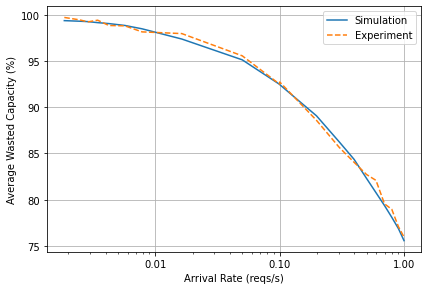

In [8]:
sim_df['utilization_percent'] = sim_df['inst_running_count_avg'] / sim_df['inst_count_avg'] * 100

plt.semilogx(exp_df['ArrivalRate'], 100 - sim_df['utilization_percent'], label='Simulation')
plt.semilogx(exp_df['ArrivalRate'], 100 - exp_df['AverageUtilization'] * 100, ls='--', label='Experiment')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylabel("Average Wasted Capacity (%)")
plt.xlabel('Arrival Rate (reqs/s)')
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gcf().subplots_adjust(left=0.11, bottom=0.11)

plt.savefig('figs/04-exp-wasted.pdf')

mape = np.mean(np.abs((sim_df['utilization_percent']/100 - exp_df['AverageUtilization'])/exp_df['AverageUtilization']))
print(f"Average Wasted MAPE: {mape:4.2f}%")